# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science:  Spotify Final Project



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader<br/>
**Group Members**: Tejal Patwardhan, Akshitha Ramachandran, Grace Zhang
<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# import necessary notebooks
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

<hr style="height:2pt">

# Data Collection and Cleaning

We collected our data by using the Spotify API to create a json file of tracks and their features, additionally labelling each track with a new feature we introduced, `in_playlist`, which equals 1 if Person X would include the track in her playlist and 0 if Person X would not include the track in her playlist. 

We accomplished this by manually creating 2 separate playlists, where one playlist includes random songs that Person X would include in her playlist and the other playlist includes random songs that Person X would not include in her playlist. We used the Spotify API `user_playlist_tracks` endpoint to collect some features, including `track_id`s, of the tracks in each of these playlists. We then used the `audio_features` endpoint of the Spotify API to get additional features like `danceability`, etc. for each of our tracks. Finally, we added the `in_playlist` feature to each of our tracks and wrote our final object to `spotify.json`.


In [ ]:
import sys
import spotipy
import spotipy.util as util
import json
from math import ceil

scope = 'user-library-read'
LIMIT = 50
PLAYLIST_1_LEN = 163
PLAYLIST_0_LEN = 897

def get_track_features_offset(playlist_id, offset, in_playlist):
    results = sp.user_playlist_tracks(
        'UroAv2poQoWSvUOfch8wmg', 
        playlist_id=playlist_id,
        limit=LIMIT,
        offset=offset,
    )
    track_infos = []
    for i in results['items']:
        track_infos.append({
            'id': i['track']['id'],
            'name': i['track']['name'],
            'popularity': i['track']['popularity'],
            'artist': i['track']['artists'][0]['name'] if len(i['track']['artists']) > 0 else None,
        })
    track_ids = [i['id'] for i in track_infos]

    tracks_features = sp.audio_features(track_ids)
    for idx, track in enumerate(tracks_features):
        track['name'] = track_infos[idx]['name']
        track['popularity'] = track_infos[idx]['popularity']
        track['artist'] = track_infos[idx]['artist']
        track['in_playlist'] = in_playlist
    return tracks_features

def get_track_features(playlist_id, num_iters, in_playlist):
    track_features = []
    for i in range(num_iters):
        track_features.extend(
            get_track_features_offset(playlist_id, i * LIMIT, in_playlist)
        )
    return track_features


# Setup
if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()
token = util.prompt_for_user_token(username, scope)
if not token: 
    print("Can't get token for", username)

sp = spotipy.Spotify(auth=token)

# Get track features
n_playlist0 = ceil(PLAYLIST_0_LEN / LIMIT)
n_playlist1 = ceil(PLAYLIST_1_LEN / LIMIT)

tracks_features0 = get_track_features('4B3qR5p6PD8nXXeq4C0Gz7', n_playlist0, 0)
tracks_features1 = get_track_features('6Jpt5r9KD8FEUDioBFV0r0', n_playlist1, 1)
tracks_features = tracks_features0 + tracks_features1

with open('spotify.json', mode='w') as f:
    f.write(json.dumps(tracks_features, indent=2))

<hr style="height:2pt">

# Data Description
Our data includes the following features:
- `danceability`: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 
- `energy`: Energy represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. A value of 0.0 is least energetic and 1.0 is most energetic. 
- `key`: The estimated overall key of the track. Integers map to pitches using standard Pitch Class Notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values range between -60 and 0 db. 
- `mode`: Mode represents the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Mode is binary; major is represented by 1 and minor is 0.
- `speechiness`: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- `acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- `liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. 
- `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- `tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 
- `duration_ms`: The duration of the track in milliseconds.
- `time_signature`: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
- `popularity`: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. 
- `in_playlist`: Response variable. Categorical variable for whether in playlist of desire. 1 if in playlist, 0 if not in playlist.

The following features were recorded to help with visualization later, but not used as predictors in our analysis, as they are not characteristics of the music itself.
- `name`: Song title
- `artist`: First artist of song
- `type`: The object type: “audio_features”
- `id`: The Spotify ID for the track.
- `uri`: The Spotify URI for the track.
- `track_href`: A link to the Web API endpoint providing full details of the track.
- `analysis_url`: An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.

# Exploratory Data Analysis

In [7]:
# load in dataset
spotify_df = pd.read_csv("data/spotify.csv")

# drop unnecessary columns
spotify_df = spotify_df.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'name', 'artist'])

In [8]:
# display head of data
display(spotify_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,in_playlist
0,0.516,0.0663,7,-19.221,0,0.0334,0.929,0.000972,0.1120,0.278,109.879,138760,4,11,0
1,0.454,0.2600,8,-13.193,0,0.0401,0.539,0.000780,0.0675,0.598,174.322,324133,5,64,0
2,0.676,0.4400,0,-11.960,1,0.0291,0.360,0.000069,0.1620,0.499,80.434,205773,4,61,0
3,0.466,0.0718,0,-17.999,1,0.0374,0.984,0.000931,0.1070,0.196,121.885,294307,4,57,0
4,0.496,0.6340,5,-10.328,0,0.0364,0.779,0.402000,0.0746,0.606,93.357,423573,4,61,0


In [9]:
# display shape of data
display(spotify_df.shape)

(1060, 15)

We have 1060 songs in our initial analysis. 163 are included in our playlist, and 897 are not included in our playlist. 

In [4]:
# generate summary chart of features
features = []
means = []
var = []
ranges = []
mins = []
maxes = []

for feature in spotify_df:
    if feature != "in_playlist":
        features.append(feature)
        means.append(spotify_df[feature].mean())
        var.append(spotify_df[feature].var())
        ranges.append(spotify_df[feature].ptp())
        mins.append(spotify_df[feature].min())
        maxes.append(spotify_df[feature].max())

summary_df = pd.DataFrame(data = {'feature': features, 
                                  'mean': means,
                                  'var' : var,
                                  'range': ranges, 
                                  'min': mins, 
                                  'max': maxes}) 

Below are summary statistics for all the features we plan to analyze:

In [5]:
display(summary_df)

,feature,mean,var,range,min,max
0,danceability,0.609826,3.191404e-02,8.896000e-01,0.070400,0.960
1,energy,0.486862,7.419323e-02,9.661700e-01,0.001830,0.968
2,key,5.224528,1.262943e+01,1.100000e+01,0.000000,11.000
3,loudness,-10.657618,4.890274e+01,4.066000e+01,-42.320000,-1.660
4,mode,0.610377,2.380414e-01,1.000000e+00,0.000000,1.000
5,speechiness,0.082250,6.951688e-03,7.168000e-01,0.023200,0.740
6,acousticness,0.446702,1.371627e-01,9.959580e-01,0.000042,0.996
7,instrumentalness,0.211497,1.281853e-01,9.870000e-01,0.000000,0.987
8,liveness,0.151008,1.277041e-02,7.868000e-01,0.021200,0.808
9,valence,0.497948,7.024889e-02,9.542000e-01,0.030800,0.985


We can see that all features have values that are expected as per the Spotify API documentation. To analyze each feature in more granularity we looked at density plots. 

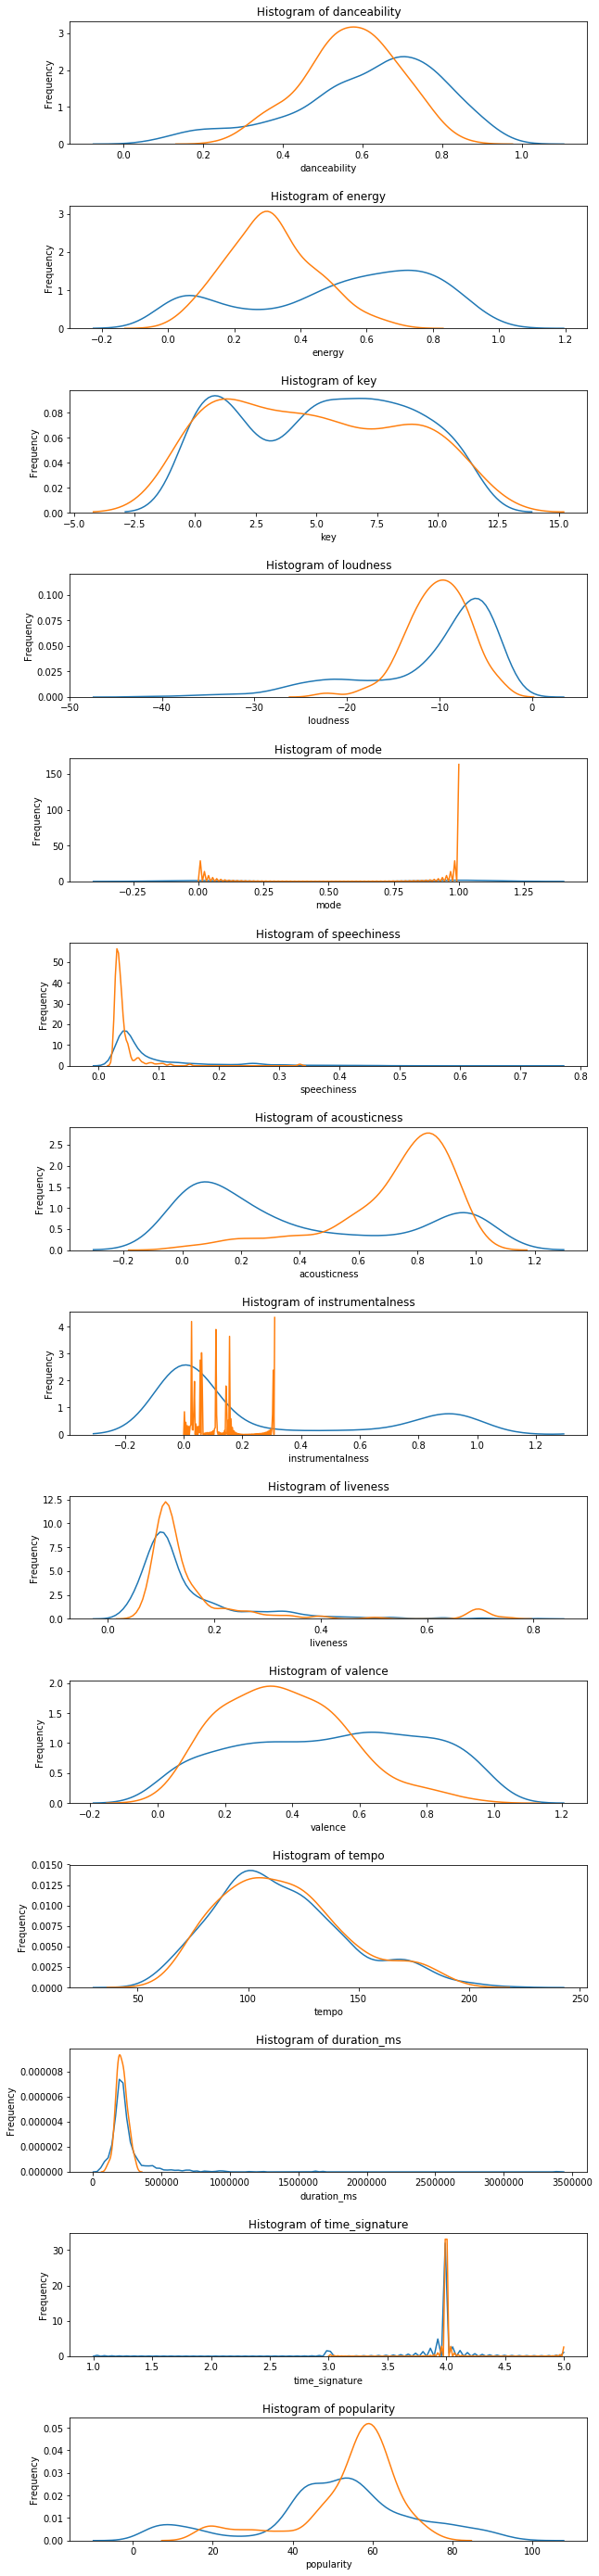

In [6]:
num_cols = len(spotify_df.columns)
nbin = 15

# iterate through all the features and display them
fig, axs = plt.subplots(num_cols - 1,1, figsize=(10,50))
for i in range(num_cols - 1):
    sns.distplot(spotify_df[spotify_df.in_playlist == 0][spotify_df.columns[i]], hist = False, kde = True, ax=axs[i])
    sns.distplot(spotify_df[spotify_df.in_playlist == 1][spotify_df.columns[i]], hist = False, kde = True, ax=axs[i])
    axs[i].set_title("Histogram of " + str(spotify_df.columns[i]))
    axs[i].set_ylabel(r'Frequency')
fig.subplots_adjust(hspace=.5)
plt.show()

Looking at the density plots above, we note some features that show clear differences in distribution between the playlist and non-playlist. 
While non-playlist songs contain a roughly uniform distribution of energy values, playlist songs spike at an energy level between 0.2-0.4.
Acousticness in playlist tracks is much higher on average, spiking around 0.8, while non-playlist tracks most frequently have acousticness values around 0.1.
Instrumentalness is a particularly interesting feature. While the distribution non-playlist tracks is bimodal, peaking at around 0 and 0.9, playlist tracks have a few very well-defined peaks between 0 and 0.3. 
We will note in advance that this may induce a risk of overfitting based on instrumentalness values.
Playlist tracks have lower loudnesses on average, centering around -10, while non-playlist tracks -5.
In terms of speechiness, the distribution for playlist tracks has a much lower variance and slightly lower expected value, centering around 0.3 while non-playlist tracks center around 0.4.
Valence for non-playlist tracks is roughly uniformly distributed, while playlist tracks demonstrate a roughly normal distribution centered around 0.3.
Finally in terms of popularity, playlist tracks show a peak in their distribution around 60, while non-playlist tracks have a more variable distribution with a peak between 45-55.
The rest of the features are roughly similar in distribution between playlist and non-playlist tracks.

# Baseline Model

# Moving Forward

So far, everything is running smoothly. We have access to the Spotify data we want, and as confirmed with Pavlos, this analysis can now be used to create the logistic and neural network models we listed in Milestone 2.